In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as op
import emcee
import scipy.stats as ss
import collections
import corner
import seaborn as sns
import random

%matplotlib inline

In [2]:
def weighted_std(values, weights):
    """
    Return the weighted average and standard deviation.
    Richard M. Brugger, "A Note on Unbiased Estimation of the Standard Deviation", The American Statistician (23) 4 p. 32 (1969)

    values, weights -- Numpy ndarrays with the same shape.
    """
    n=len(values)
    average = np.average(values, weights=weights)
    variance = (n/(n-1.5))*np.average((values-average)**2, weights=weights)  # Fast and numerically precise
    return np.sqrt(variance)

In [3]:
df=pd.read_csv("NED27.02.1-D-14.1.0-20170227.csv",skiprows=12)
df=df[np.isnan(df['redshift (z)'])]
df=df[np.isfinite(df.err)]

In [4]:
meth=[]
ndat=[]
for i in np.unique(df.Method)[:-3]:
    df2=df[df.Method==i]
    df1=df[df.Method=='Tully-Fisher']
    meth+=[i]
    ndat+=[df2.shape[0]]
info=pd.DataFrame({'method':meth,'nrows':ndat})

In [5]:
namelist=list(df1['Galaxy ID']) # list of galaxies
counter=collections.Counter(namelist) # count measurements p. galaxy
# select galaxies with a minimum number of measurements
ulist=[]
nmeas=3
for i in counter.keys():
    if counter[i]>nmeas:
        ulist+=[i]
dfs=df1[np.in1d(df1['Galaxy ID'],ulist)] # short dataframe
disterr=0.461*dfs['D (Mpc)']*dfs.err 
len(ulist)

5234

In [6]:
%%time
nbins=10000 # 
names=[]
em=[] # 0
bootp50=[] #1
bootsig=[] #2
derr=[] #3
dmean=[] #4
rmserr=[] #5
dboot=[] #6
wstd=[]
for i in ulist:
    dfilter=np.in1d(dfs['Galaxy ID'],i)
    dummy=dfs[dfilter]
    names+=[i]
    em+=[len(dummy)]
    tli=[]
    for km,ke in zip(dummy['m-M'],dummy['err']):
        tli+=[list(10**(np.random.normal(km,ke,nbins)/5.+1))]
    booterr=np.percentile(tli, 84,axis=0)/1e6-np.percentile(tli, 16,axis=0)/1e6
    bootmean=np.mean(tli,axis=0) # rms -- is it useful?
    dumerr=disterr[dfilter]
    wstd+=[weighted_std(dummy['D (Mpc)'],dumerr)]
    derr+=[dumerr.mean()] # average reported error (Delta) -- is it useful?
    bootp50+=[np.mean(booterr)] # mean bootstrap error
    bootsig+=[(np.percentile(booterr, 84)-np.percentile(booterr, 16))] # the error of the error
    dmean+=[dummy['D (Mpc)'].mean()] # average reported distance (D) 5 here, 6 in bootstrap sampling.ipynb
#    rmserr+=[np.linalg.norm(dumerr/dummy['D (Mpc)'])*dmean] # rms error (D)
    dboot+=[np.mean(bootmean)/1e6] # bootstrap mean D

CPU times: user 2min 12s, sys: 4 ms, total: 2min 12s
Wall time: 2min 13s


In [7]:
def lnlikelin(theta, x, y,yerr):# modelo lineal (D,wstd) independiente de sigma_sigma
    m ,b = theta
    model = m * x**2 + b**2
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnpriorlin(theta):
    m, b = theta
    if 0 < m < 10 and 0 < b < 50:
        return 0.0
    return -np.inf
# Posterior probability
def lnproblin(theta, x, y,yerr):
    lp = lnpriorlin(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlikelin(theta, x, y,yerr)

In [14]:
# en este punto no es necesario graficar los resultados del mcmc, pero valdría la pena dejarlo correr mas? 
# tambien se podrian pesar cada samples, pero no pienso que sea correcto
bdist=np.array([])
mdist=np.array([])
coun=0
for i in range(5,26): # sin el yerr al cuadrado da buenos resultados para el errsist, hay que comparar los y_sim
    filt=np.array(em)>i
    filt.sum()
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
    y=y**2
    yerr=yerr**2
#    nll = lambda *args: -lnlikelin(*args)
#    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    m_ml, b_ml = (1,4)
#    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnproblin, args=(x, y,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    bdist=np.hstack((bdist,samples[:,1]))
    mdist=np.hstack((mdist,samples[:,0]))
    print(i,samples.mean(axis=0))
    coun+=1

5 [ 0.11713334  3.71272025]
6 [ 0.12075589  3.61670837]
7 [ 0.12506031  3.48413733]
8 [ 0.12632327  3.44311413]
9 [ 0.12875525  3.25091291]
10 [ 0.12891894  3.18265754]
11 [ 0.12274428  5.00451524]
12 [ 0.1166321   5.26712827]
13 [ 0.10630096  5.5839297 ]
14 [ 0.10775168  5.85079722]
15 [ 0.11383768  5.58581384]
16 [ 0.11726064  5.43290421]
17 [ 0.11366428  5.42144243]
18 [ 0.10784288  5.7099336 ]
19 [ 0.09234805  5.92623947]
20 [ 0.07730987  6.18521032]
21 [ 0.07849793  6.4603072 ]
22 [ 0.19184351  4.21572489]
23 [ 0.27995412  0.00694959]
24 [ 0.2862403   0.00600205]
25 [ 0.21761926  3.48669641]


15 [ 0.00412615  2.38598114]
Rejection rate = 100 %
16 [ 0.00410427  2.2741868 ]
Rejection rate = 100 %
17 [ 0.00414484  2.32310752]
Rejection rate = 100 %
18 [ 0.00380702  2.41682072]
Rejection rate = 100 %
19 [ 0.00351205  2.40932232]
Rejection rate = 100 %
20 [ 0.00324021  2.40094836]
Rejection rate = 100 %
21 [ 0.0035776   2.47626619]
Rejection rate = 100 %
22 [ 0.00905003  2.07935452]
Rejection rate = 100 %
23 [ 0.01637604  1.79765069]
Rejection rate = 99 %
Bayesian p-value: 0.0
24 [ 0.01618641  1.78326413]
Rejection rate = 99 %
Bayesian p-value: 0.0
25 [ 0.01325181  1.36977426]


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt


Rejection rate = 98 %
Bayesian p-value: 0.0


/home/ecci/miniconda3/envs/py3/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in less


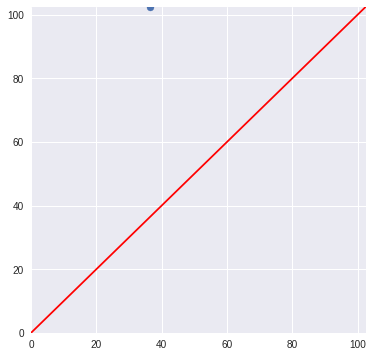

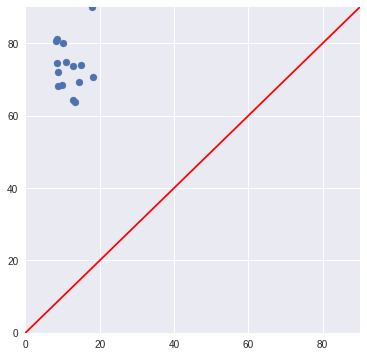

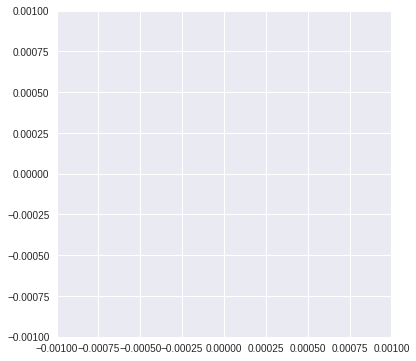

In [85]:
# en este punto no es necesario graficar los resultados del mcmc, pero valdría la pena dejarlo correr mas? 
# tambien se podrian pesar cada samples, pero no pienso que sea correcto
bdist=np.array([])
mdist=np.array([])
coun=0
for i in range(15,26): # sin el yerr al cuadrado da buenos resultados para el errsist, hay que comparar los y_sim
    filt=np.array(em)>i
    filt.sum()
    x=np.array(dboot)[filt]
    y=np.array(bootp50)[filt]
    #yerr=np.array(wstd)[filt] # wstd
    yerr=np.array(bootsig)[filt]
#    y=y**2
#    yerr=yerr**2
#    nll = lambda *args: -lnlikelin(*args)
#    result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
    m_ml, b_ml = (1,4)
#    if b_ml > 0:
    ndim, nwalkers = len(result["x"]), 100
    pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
    sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=(x, y,yerr)) 
    # 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
    sampler.run_mcmc(pos, 1000);
    # Here we remove the burn-in steps, which we estimate to be around 100. 
    # This can be estimated by calculating the autocorrelation time (see below)
    samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
    bdist=np.hstack((bdist,samples[:,1]))
    mdist=np.hstack((mdist,samples[:,0]))
    print(i,samples.mean(axis=0))
    coun+=1
    discrep1(samples,x,y,yerr)

In [77]:
samples[np.random.randint(len(samples))]

array([ 0.21950892,  3.28915728])

In [81]:
def discrep(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//10
    for i in range(ndisc):
        yexp=samples[i,0]*x**2+samples[i,1]**2
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x**2+modpar[1]**2,yerr)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
            yexp=np.sqrt(yexp)
            ysim=np.sqrt(ysim)
            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

In [ ]:
plt.scatter(x,polynomial_fit(np.asarray(df_2D.iloc[0]),x)) # expected value: y_exp(theta_i)
plt.scatter(x,y) # data
plt.scatter(x,np.random.normal(polynomial_fit(np.asarray(df_2D.mean()),x),yerr)) # y_sim(theta_i)

In [111]:
def lnlike1(theta, x, y,yerr):# modelo lineal (D,wstd) independiente de sigma_sigma
    m ,b = theta
    model = m * x + b
    inv_sigma2 = 1.0/(yerr**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior1(theta):
    m, b = theta
    if -10 < m < 10 and -50 < b < 50:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob1(theta, x, y,yerr):
    lp = lnprior1(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike1(theta, x, y,yerr)

In [112]:
def discrep1(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//10
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1]
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x+modpar[1],yerr)
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

26 0.317893224873 2.54061097661
26 [ 0.31427538  2.61726029]
Rejection rate = 5 %
Bayesian p-value: 0.914326007756


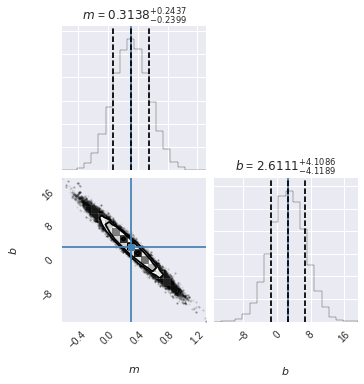

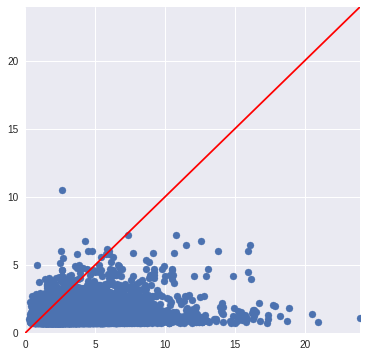

In [118]:
i=26
filt=np.array(em)>i
filt.sum()
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
#    y=y**2
#    yerr=yerr**2
nll = lambda *args: -lnlike1(*args)
result = op.minimize(nll, [1.]*2, args=(x, y,yerr))
m_ml, b_ml = result["x"]
print(i,m_ml,b_ml)
#    if b_ml > 0:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob1, args=(x, y,yerr)) 
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
bdist=np.hstack((bdist,samples[:,1]))
mdist=np.hstack((mdist,samples[:,0]))
sth=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
print(i,sth)
coun+=1
discrep1(samples,x,y,yerr)

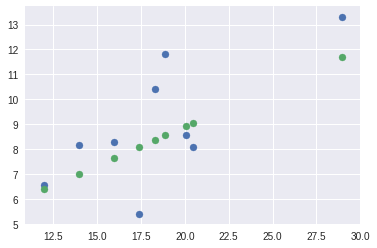

In [119]:
plt.scatter(x,y)
plt.scatter(x,sth[0]*x+sth[1])


In [181]:
def lnlike2(theta, x, y,yerr):# modelo que usa una fracción de sigma_sigma
    m ,b, f = theta
    model = m * x + b    
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior2(theta):
    m, b, f = theta
    if -10 < m < 10 and -50 < b < 50 and 0 < f < 1.1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob2(theta, x, y,yerr):
    lp = lnprior2(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike2(theta, x, y,yerr)

def discrep2(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//10
    for i in range(ndisc):
        yexp=samples[i,0]*x+samples[i,1]
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x+modpar[1],(modpar[0]*x+modpar[1])*modpar[2])
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

9
26 0.356778173241 2.36943031211 0.184487983765
26 [ 0.36595324  2.24950984  0.25508761]
Rejection rate = 2 %
Bayesian p-value: 0.940239043825


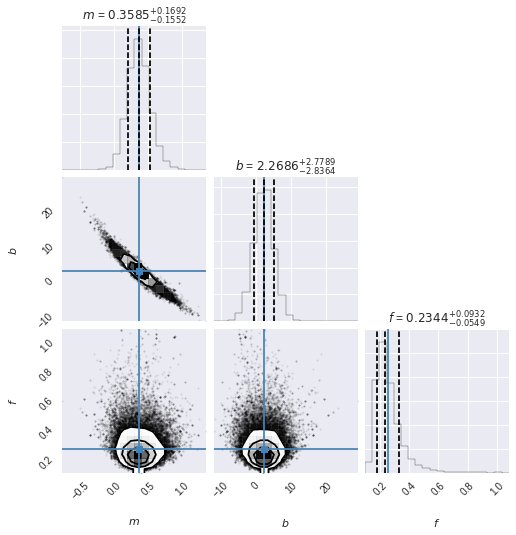

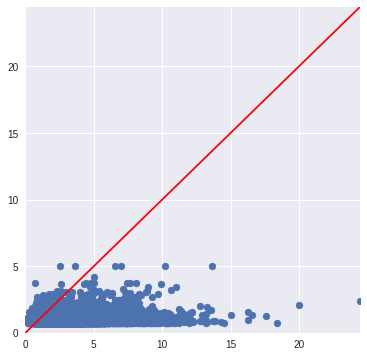

In [189]:
i=26
filt=np.array(em)>i
print(filt.sum())
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
#    y=y**2
#    yerr=yerr**2
nll = lambda *args: -lnlike2(*args)## AQUI
result = op.minimize(nll, [1.]*3, args=(x, y,yerr)) ## AQUI
m_ml, b_ml,f_ml = result["x"]## AQUI
print(i,m_ml,b_ml,f_ml)## AQUI
#    if b_ml > 0:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob2, args=(x, y,yerr)) ## AQUI
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
bdist=np.hstack((bdist,samples[:,1]))
mdist=np.hstack((mdist,samples[:,0]))
sth=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
print(i,sth)
coun+=1
discrep1(samples,x,y,yerr)

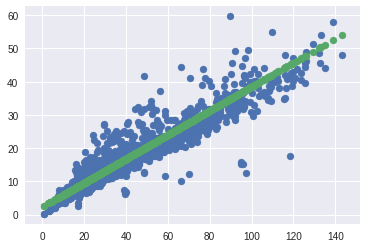

In [186]:
plt.scatter(x,y)
plt.scatter(x,sth[0]*x+sth[1])

(0, 50.0)

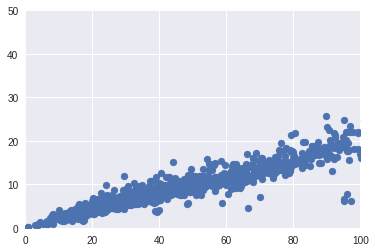

In [185]:
i=10
myx=100
filt=np.array(em)>i
filt.sum()
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
plt.scatter(x,yerr)
plt.xlim(0,myx)
plt.ylim(0,myx/2)

In [215]:
def lnlike3(theta, x, y,yerr):# modelo que usa una fracción de sigma_sigma
    m ,b, f = theta
    model = m * x**2 + b**2    
    inv_sigma2 = 1.0/((f*model)**2)
    return -0.5*(np.sum((y-model)**2*inv_sigma2 - np.log(2*np.pi*inv_sigma2)))
def lnprior3(theta):
    m, b, f = theta
    if 0 < m < 10 and 0 < b < 50 and 0 < f < 1:
        return 0.0
    return -np.inf
# Posterior probability
def lnprob3(theta, x, y,yerr):
    lp = lnprior3(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike3(theta, x, y,yerr)

def discrep3(samples,x,y,yerr):
    discs=[]
    disco=[]
    rej=0
    ndisc=len(samples)//100
    for i in range(ndisc):
        yexp=samples[i,0]*x**2+samples[i,1]**2
        modpar=samples[np.random.randint(len(samples))]
        ysim=np.random.normal(modpar[0]*x**2+modpar[1]**2,modpar[2]*(modpar[0]*x**2+modpar[1]**2))
        if np.any(ysim<0)|np.any(ysim<0):
            rej+=1
        else:        
#            yexp=np.sqrt(yexp)
#            ysim=np.sqrt(ysim)
#            y=np.sqrt(y)
#            discs+=[((ysim-yexp)**2).sum()]
#            disco+=[((y-yexp)**2).sum()]
            discs+=[((np.sqrt(ysim)-np.sqrt(yexp))**2).sum()]
            disco+=[((np.sqrt(y)-np.sqrt(yexp))**2).sum()]
    print("Rejection rate =",100*rej//ndisc,"%") # rejection rate
    if 100*rej//ndisc < 100:
        discs=np.array(discs)
        disco=np.array(disco)
        plt.figure(figsize=(6,6))
        plt.scatter(discs,disco)
        dmax=np.max(np.hstack((disco,discs)))
        ppp=np.linspace(0,dmax,2)
        plt.plot(ppp,ppp,c='r')
        plt.xlim(0,dmax)
        plt.ylim(0,dmax)
        print("Bayesian p-value:", (disco<discs).sum()*1./len(disco))

53
22 0.0111355711787 2.29560353153 0.232420589766
22 [ 0.01122963  2.28719513  0.24269554]
Rejection rate = 0 %
Bayesian p-value: 0.207589285714


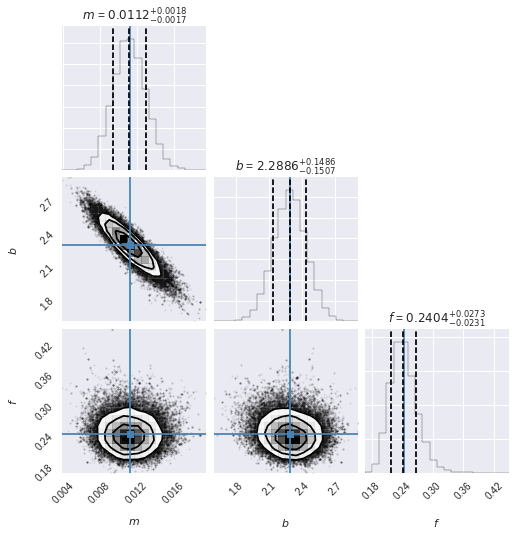

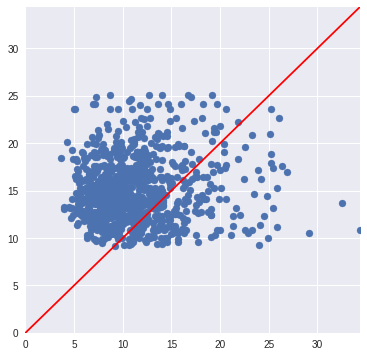

In [218]:
i=22
filt=np.array(em)>i
print(filt.sum())
x=np.array(dboot)[filt]
y=np.array(bootp50)[filt]
yerr=np.array(bootsig)[filt]
#    y=y**2
#    yerr=yerr**2
nll = lambda *args: -lnlike3(*args)## AQUI
result = op.minimize(nll, [1.]*3, args=(x, y,yerr)) ## AQUI
m_ml, b_ml,f_ml = result["x"]## AQUI
print(i,m_ml,b_ml,f_ml)## AQUI
#    if b_ml > 0:
ndim, nwalkers = len(result["x"]), 100
pos = [result["x"] + 1e-4*np.random.randn(ndim) for i in range(nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob3, args=(x, y,yerr)) ## AQUI
# 2. Let the walkers walk 1000 steps (10000 will do the trick as well)
sampler.run_mcmc(pos, 1000);
# Here we remove the burn-in steps, which we estimate to be around 100. 
# This can be estimated by calculating the autocorrelation time (see below)
samples = sampler.chain[:, 100:, :].reshape((-1, ndim)) 
bdist=np.hstack((bdist,samples[:,1]))
mdist=np.hstack((mdist,samples[:,0]))
sth=samples.mean(axis=0)
fig = corner.corner(samples, labels=["$m$", "$b$","$f$"],truths=sth, quantiles=[0.16, 0.5, 0.84], show_titles=True,title_fmt='.4f')
print(i,sth)
coun+=1
discrep3(samples,x,y,yerr)

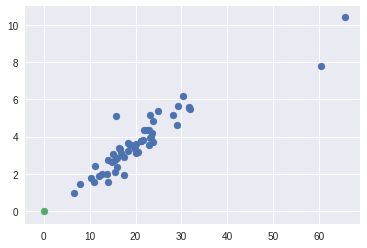

In [221]:
plt.scatter(x,yerr)
plt.scatter([0],[0])

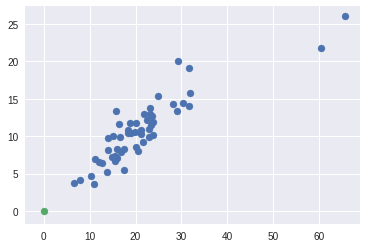

In [222]:
plt.scatter(x,y)
plt.scatter([0],[0])